### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import tslearn

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from tslearn.barycenters import euclidean_barycenter, dtw_barycenter_averaging, dtw_barycenter_averaging_subgradient,softdtw_barycenter
import random
import time
from scipy.cluster.hierarchy import dendrogram, linkage, ward, fcluster

from sklearn.preprocessing import MinMaxScaler, StandardScaler

pd.set_option("display.max_columns", None)


Bad key text.latex.preview in file C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       

In [2]:
# Create color class

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    

### Load data and data preparation

In [3]:
# Load data

aki = pd.read_excel("ThaiAKIepi_clean.xlsx")

In [4]:
# Select only AKI + sepsis patients

aki = aki.loc[(aki["akiny"] == 1) & (aki["akicause_revised_n"] == "Sepsis") ]
aki.shape

(1162, 114)

In [5]:
# use only row that have all cretinine info

aki = aki[aki["crref_use"].notna()]
aki = aki[aki["creatinine_1"].notna()]
aki = aki[aki["creatinine_2"].notna()]
aki = aki[aki["creatinine_3"].notna()]
aki = aki[aki["creatinine_4"].notna()]
aki = aki[aki["creatinine_5"].notna()]

In [6]:
# Interested columns

columns = ["age","sexfac_n","weight","cardiodis","renaldis","infectdis","gastrodis","hematodis","neurodis","rheumdis","oncoldis","surgdis","ht_n","dm_n","ckd_n","cad_n","cvd","malignancy_n","apache_ii","sofa_nonrenal_n","percentfluid_1",
          "vaso_n","mechvent_n","maxakinom","time2aki_n","rrt_any","hoslos_n","hospital_discharge_status_n","icu_los_n","icu_discharge_status_n","recovery_n","crref_use","creatinine_1","creatinine_2","creatinine_3","creatinine_4","creatinine_5"]

In [7]:
aki_select = aki[columns]
print(f"AKI Sepsis number of rows : {aki_select.shape[0]} | columns : {aki_select.shape[1]}")
aki_select.head(5)

AKI Sepsis number of rows : 173 | columns : 37


,age,sexfac_n,weight,cardiodis,renaldis,infectdis,gastrodis,hematodis,neurodis,rheumdis,oncoldis,surgdis,ht_n,dm_n,ckd_n,cad_n,cvd,malignancy_n,apache_ii,sofa_nonrenal_n,percentfluid_1,vaso_n,mechvent_n,maxakinom,time2aki_n,rrt_any,hoslos_n,hospital_discharge_status_n,icu_los_n,icu_discharge_status_n,recovery_n,crref_use,creatinine_1,creatinine_2,creatinine_3,creatinine_4,creatinine_5
8,63.0,Male,70.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,Yes,No,No,0.0,0.0,22.0,11.0,0.985714,0.0,Yes,3.0,1.0,1.0,19.0,0.0,4.0,0.0,1.0,3.3,0.87,0.95,0.89,0.9,1.47
51,75.0,Female,68.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,No,No,No,0.0,0.0,25.0,7.0,-0.941176,0.0,Yes,3.0,1.0,1.0,18.0,1.0,17.0,1.0,0.0,2.2,4.60,4.97,5.48,4.97,5.7
85,78.0,Female,55.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,Yes,No,No,0.0,0.0,32.0,12.0,-0.781818,1.0,Yes,3.0,1.0,1.0,24.0,0.0,7.0,0.0,0.0,0.8,2.22,2.73,2.37,2.07,1.58
118,68.0,Female,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,Yes,No,No,0.0,0.0,22.0,6.0,0.615385,0.0,Yes,3.0,1.0,0.0,13.0,1.0,7.0,1.0,0.0,0.8,3.10,3.10,3.10,3,3.1
143,78.0,Male,58.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,No,No,No,No,0.0,0.0,29.0,11.0,-1.224138,1.0,Yes,3.0,1.0,1.0,47.0,1.0,2.0,1.0,0.0,1.8,0.96,3.25,4.02,5.37,6.8


In [8]:
aki_select["creatinine_4"] = aki_select["creatinine_4"].astype(float)
aki_select["creatinine_5"] = aki_select["creatinine_5"].astype(float)

C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
print(color.BOLD + "Overall stats in AKI sepsis" + color.END)
aki_select.describe()

Overall stats in AKI sepsis


,age,weight,cardiodis,renaldis,infectdis,gastrodis,hematodis,neurodis,rheumdis,oncoldis,surgdis,cvd,malignancy_n,apache_ii,sofa_nonrenal_n,percentfluid_1,vaso_n,maxakinom,time2aki_n,rrt_any,hoslos_n,hospital_discharge_status_n,icu_los_n,icu_discharge_status_n,recovery_n,crref_use,creatinine_1,creatinine_2,creatinine_3,creatinine_4,creatinine_5
count,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,172.000000,173.000000,173.000000,171.000000,172.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000
mean,67.156069,60.375723,0.473988,0.173410,0.895954,0.098266,0.040462,0.028902,0.023121,0.005780,0.028902,0.069364,0.040698,22.560694,7.832370,1.442696,0.563953,2.526012,1.312139,0.184971,20.705202,0.520231,9.699422,0.387283,0.202312,1.418555,2.641792,2.680925,2.662890,2.561618,2.483584
std,16.617234,14.683993,0.500772,0.379701,0.306207,0.298538,0.197613,0.168017,0.150725,0.076029,0.168017,0.254810,0.198166,6.495353,3.886574,2.926978,0.497341,0.727903,2.216671,0.389401,23.900224,0.501041,10.667373,0.488543,0.402890,1.748549,2.968135,2.681924,2.693869,2.649145,2.437394
min,16.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,-5.857143,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.400000,0.460000,0.340000,0.290000,0.200000,0.300000
25%,59.000000,50.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,5.000000,-0.505914,0.000000,2.000000,1.000000,0.000000,6.000000,0.000000,3.000000,0.000000,0.000000,0.780000,0.940000,1.000000,0.990000,0.860000,0.850000
50%,70.000000,60.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,8.000000,1.253846,1.000000,3.000000,1.000000,0.000000,13.000000,1.000000,6.000000,0.000000,0.000000,1.000000,1.600000,1.800000,1.700000,1.500000,1.530000
75%,80.000000,70.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.000000,10.000000,2.752644,1.000000,3.000000,1.000000,0.000000,29.000000,1.000000,12.000000,1.000000,0.000000,1.150000,3.100000,3.130000,3.500000,3.270000,3.170000
max,93.000000,115.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,42.000000,19.000000,13.153846,1.000000,3.000000,21.000000,1.000000,167.000000,1.000000,73.000000,1.000000,1.000000,17.750000,25.080000,20.690000,20.770000,20.230000,16.180000


In [10]:
# ROC of creatinine from baseline

aki_5days_complete = aki_select

aki_5days_complete.rename(columns={"crref_use":"baseline"},inplace=True)

aki_5days_complete["ROC_1"] = (aki_5days_complete["creatinine_1"] - aki_5days_complete["baseline"])/aki_5days_complete["baseline"] * 100
aki_5days_complete["ROC_2"] = (aki_5days_complete["creatinine_2"] - aki_5days_complete["baseline"])/aki_5days_complete["baseline"] * 100
aki_5days_complete["ROC_3"] = (aki_5days_complete["creatinine_3"] - aki_5days_complete["baseline"])/aki_5days_complete["baseline"] * 100
aki_5days_complete["ROC_4"] = (aki_5days_complete["creatinine_4"] - aki_5days_complete["baseline"])/aki_5days_complete["baseline"] * 100
aki_5days_complete["ROC_5"] = (aki_5days_complete["creatinine_5"] - aki_5days_complete["baseline"])/aki_5days_complete["baseline"] * 100


C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [11]:
# Create function to encode data

def convert(x):
    if x["ht_n"] == "Yes":
        x["ht_n"] = 1
    else:
        x["ht_n"] = 0
        
    if x["dm_n"] == "Yes":
        x["dm_n"] = 1
    else:
        x["dm_n"] = 0
        
    if x["ckd_n"] == "Yes":
        x["ckd_n"] = 1
    else:
        x["ckd_n"] = 0
        
    if x["cad_n"] == "Yes":
        x["cad_n"] = 1
    else:
        x["cad_n"] = 0
        
    if x["mechvent_n"] == "Yes":
        x["mechvent_n"] = 1
    else:
        x["mechvent_n"] = 0
    
    if x["sexfac_n"] == "Female":
        x["sexfac_n"] = 1
    else:
        x["sexfac_n"] = 0
    
    return x
    

In [12]:
aki_5days_complete = aki_5days_complete.apply(convert, axis=1)

In [13]:
# Check data types of each columns

aki_5days_complete.dtypes

age                            float64
sexfac_n                         int64
weight                         float64
cardiodis                      float64
renaldis                       float64
infectdis                      float64
gastrodis                      float64
hematodis                      float64
neurodis                       float64
rheumdis                       float64
oncoldis                       float64
surgdis                        float64
ht_n                             int64
dm_n                             int64
ckd_n                            int64
cad_n                            int64
cvd                            float64
malignancy_n                   float64
apache_ii                      float64
sofa_nonrenal_n                float64
percentfluid_1                 float64
vaso_n                         float64
mechvent_n                       int64
maxakinom                      float64
time2aki_n                     float64
rrt_any                  

In [14]:
columns = ["ROC_1", "ROC_2", "ROC_3", "ROC_4", "ROC_5"]
aki_5days_complete = aki_5days_complete[columns]

In [15]:
# Scaling data with standard scaler

scaler = StandardScaler()
scaler.fit(aki_5days_complete)
aki_5days_complete_scale = scaler.transform(aki_5days_complete)
aki_5days_complete_scale[:5]

array([[-0.74147601, -0.76605198, -0.76739072, -0.76208442, -0.76348084],
       [-0.17724864, -0.1387432 , -0.04863079, -0.09387367,  0.06077874],
       [ 0.03398575,  0.228312  ,  0.10397088,  0.01660283, -0.17584662],
       [ 0.37364501,  0.37549571,  0.39924589,  0.40766668,  0.55411209],
       [-0.65819866, -0.28307402, -0.13197945,  0.14976081,  0.51676046]])

In [16]:
# Calculate distance between time series
ds_scale = dtw.distance_matrix(aki_5days_complete_scale)

### Hierachical clustering and heatmap with dendrogram

C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


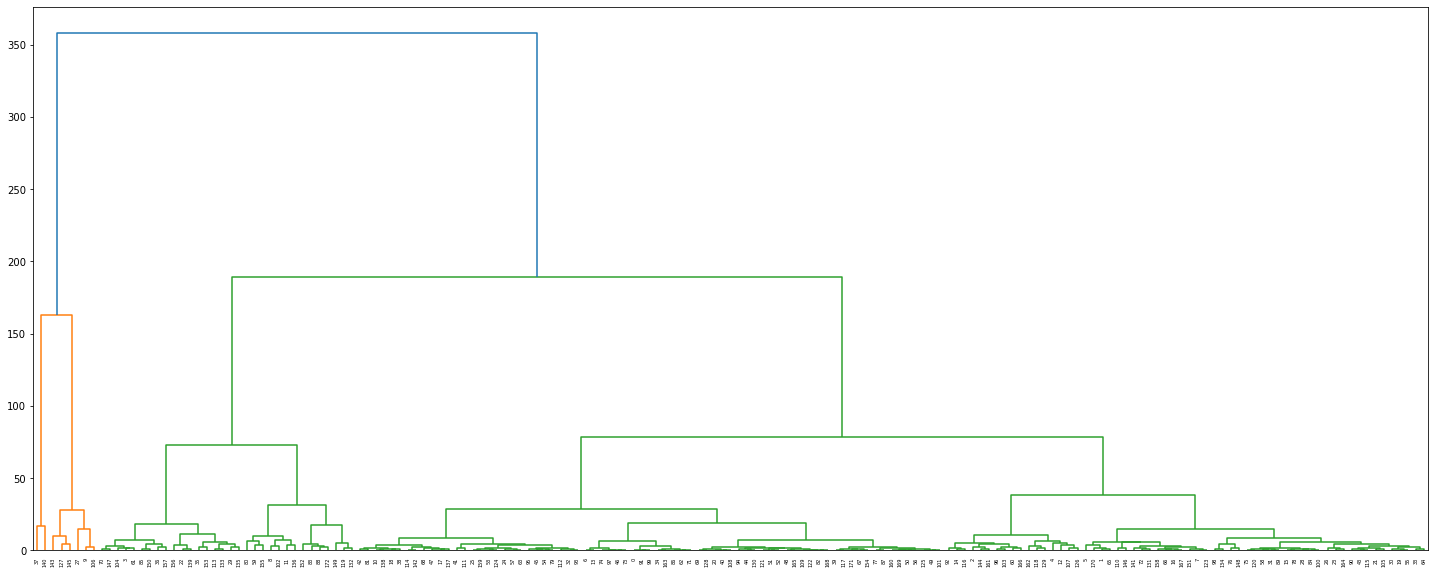

In [17]:
z_scale = linkage(ds_scale, "ward")
fig = plt.figure(figsize=(25,10))
dn = dendrogram(z_scale)

C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


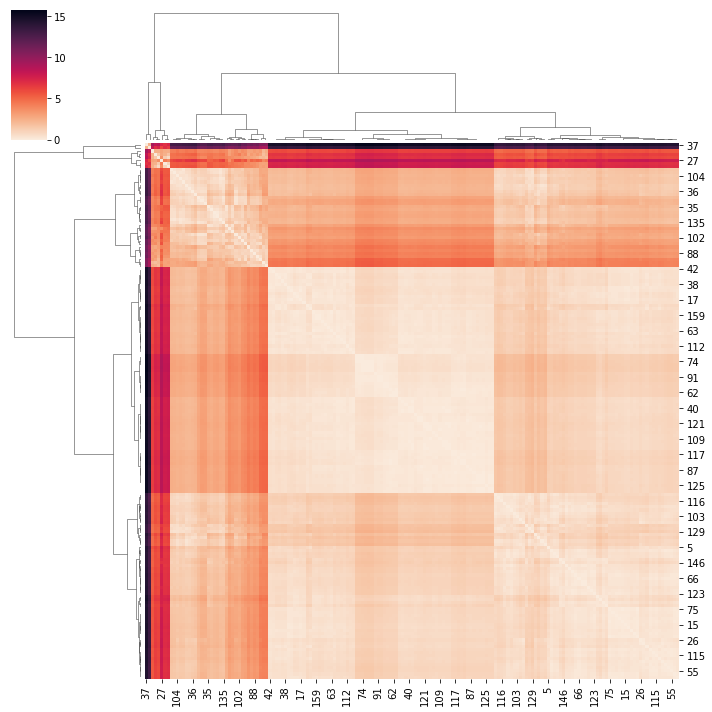

In [18]:
g_scale = sns.clustermap(ds_scale, method="ward", cmap="rocket_r")

### Dimension reduction with PCA

[4.73193371 0.16100851]


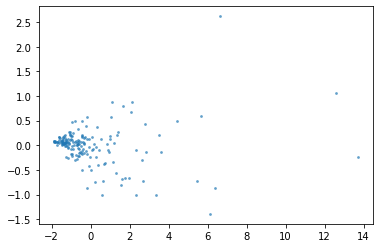

In [19]:
from sklearn.decomposition import PCA
#PCA with two principal components
PCA_2d = PCA(n_components=2).fit(aki_5days_complete_scale)
#PCA_2d.head()
print(PCA_2d.explained_variance_)
PCA_2d = PCA(n_components=2).fit_transform(aki_5days_complete_scale)
plt.scatter(PCA_2d[:, 0], PCA_2d[:, 1], marker='.', s=30, lw=0, alpha=0.7, edgecolor='k');

### Silhouette Analysis

Silhouette score of 2 clusters : 0.7925812493577276
Silhouette score of 3 clusters : 0.6169926606021965
Silhouette score of 4 clusters : 0.6259327544401146
Silhouette score of 5 clusters : 0.4571774431030446
Silhouette score of 6 clusters : 0.44442657024501897
Silhouette score of 7 clusters : 0.3964383414717429


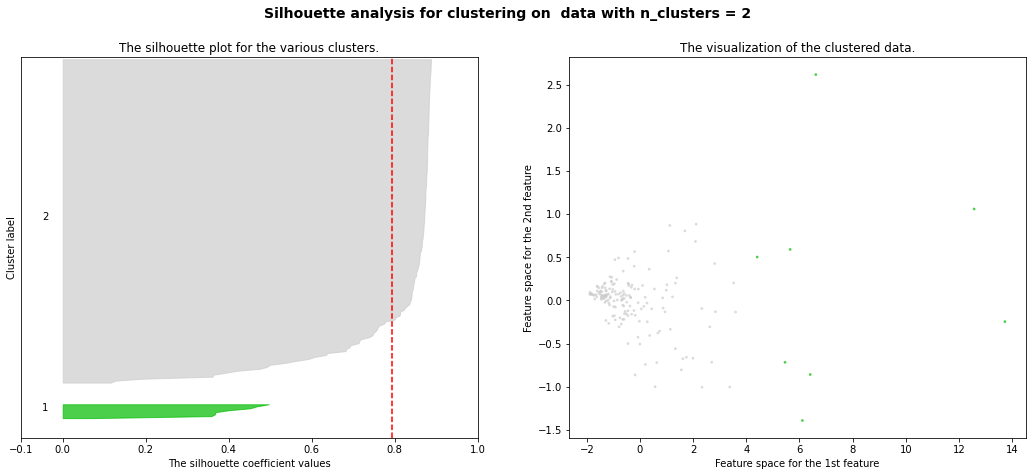

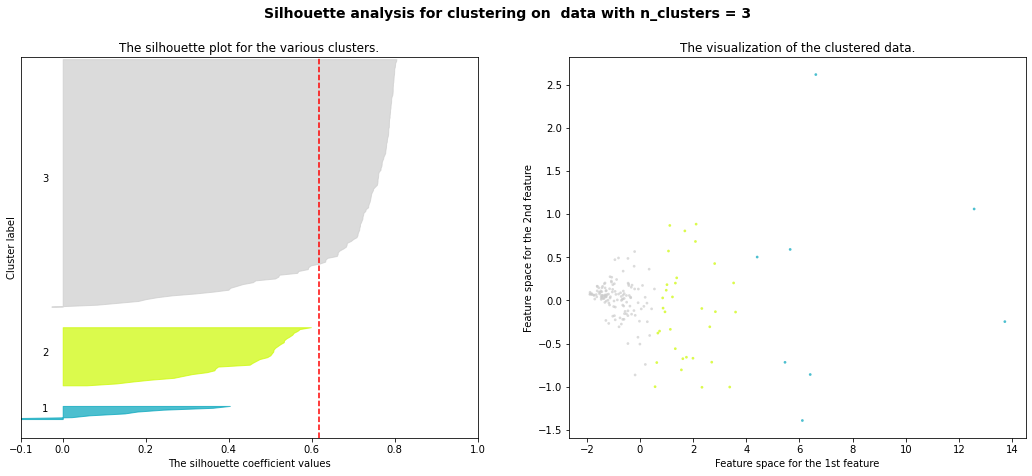

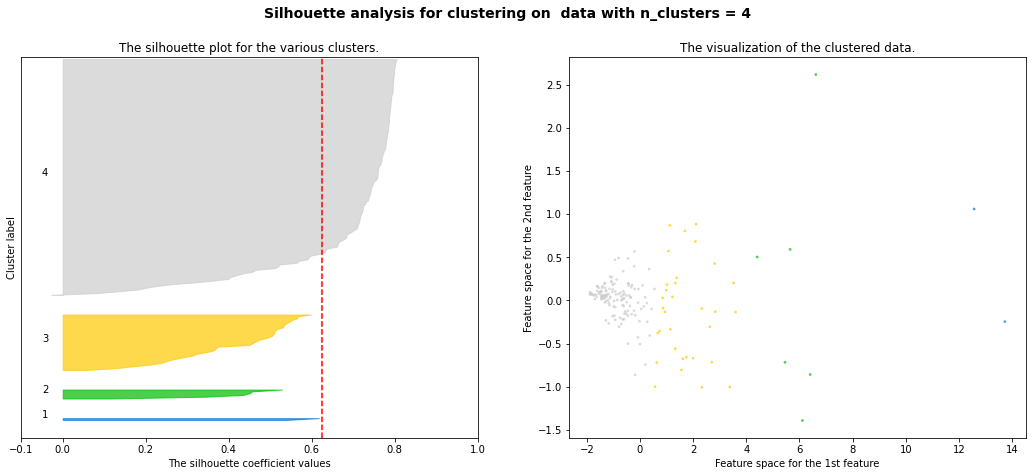

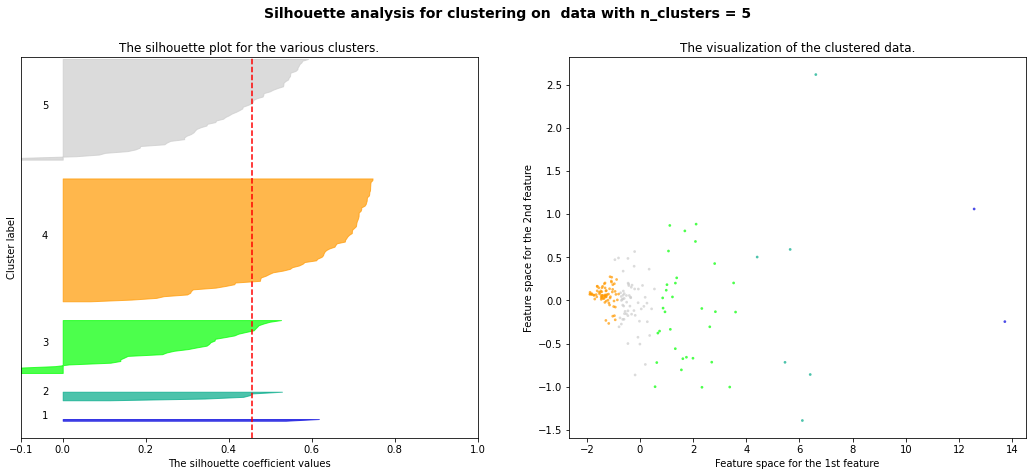

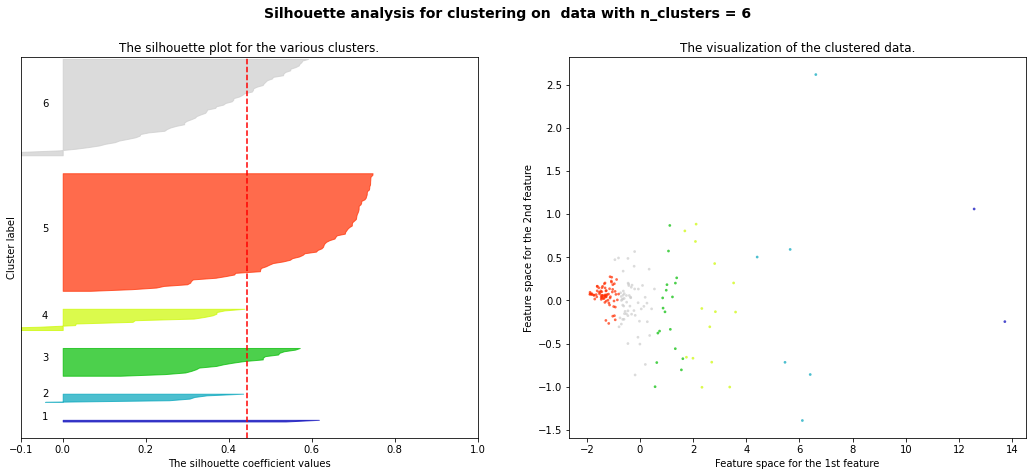

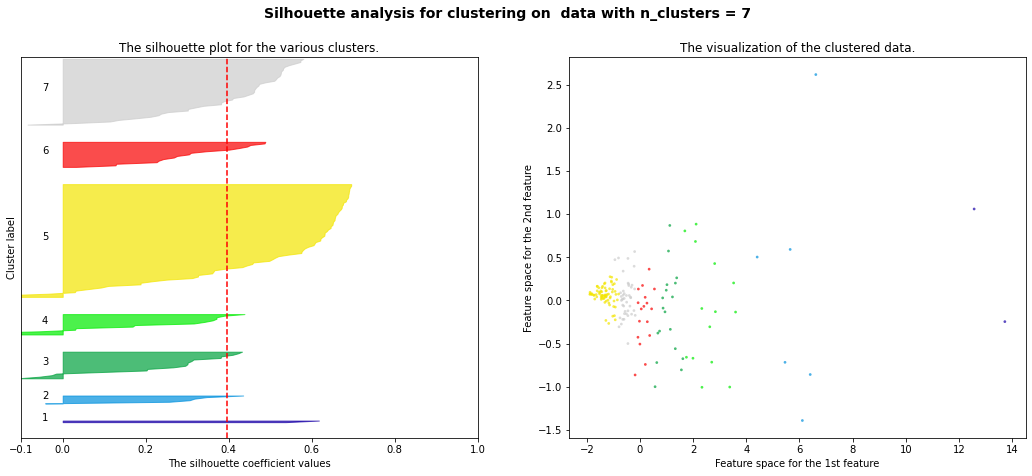

In [20]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.cm as cm


threshold_level = {2:250, 3:175, 4:100, 5:75, 6:50, 7:35}

for n_clusters in range(2,8):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18,7)
    
     # The 1st subplot is the silhoueete plot (range -1,1)
    ax1.set_xlim([-0.1, 1])
     # The (n_cluster+1) *10 is for inserting blank space between silhouette
    ax1.set_ylim([0, aki_5days_complete.shape[0] + (n_clusters*10)])
    
    cluster_scale = fcluster(z_scale, t=threshold_level[n_clusters], criterion="distance")
    silhouette_avg =  silhouette_score(aki_5days_complete_scale, cluster_scale)
    print(f"Silhouette score of {n_clusters} clusters : {silhouette_avg}")
    
    y_lower = 10
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(aki_5days_complete_scale, cluster_scale)
    
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_scale == i+1]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i+1) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral((cluster_scale.astype(float)) / n_clusters)
    ax2.scatter(PCA_2d[:, 0], PCA_2d[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

   

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for clustering on  data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### Threshold at 100 --> 4 clusters

In [21]:
# label each patient with threshold=100
cluster_scale_2 = fcluster(z_scale, t=100, criterion="distance")

In [22]:
# Check number of each clusters
unique_scale_2, counts_scale_2 = np.unique(cluster_scale_2, return_counts=True)
dict(zip(unique_scale_2, counts_scale_2))

{1: 2, 2: 6, 3: 32, 4: 133}

In [23]:
# Concat label back to creatinine array
aki_5days_scale_label_2 = np.column_stack((aki_5days_complete_scale, cluster_scale_2))

In [24]:
columns_value = ["ROC_1", "ROC_2", "ROC_3", "ROC_4", "ROC_5", "label"]
df_scale_2 = pd.DataFrame(aki_5days_scale_label_2, columns=columns_value)

In [25]:
def plot_helper(barycenter):
    # plot all points of the data set
    for series in q:
        series = np.append([0], series)
        plt.plot(series.ravel(), "k-", alpha=.2)
    # plot the given barycenter of them
    #plt.plot(barycenter.ravel(), "r-", linewidth=2)
    b = dtw_barycenter_averaging_subgradient(q, max_iter=100, tol=1e-3)
    ar1 = []
    ar2 = []
    for i,j in enumerate(b):
        x = ar1.append(i)
        y = ar2.append(j[0])
    plt.plot(range(1, 1+len(ar2)),ar2, c="r")
    

C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\tslearn\barycenters\dba.py:736: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  "Stopping optimization.", ConvergenceWarning)
C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\tslearn\barycenters\dba.py:736: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  "Stopping optimization.", ConvergenceWarning)
C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\tslearn\barycenters\dba.py:736: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  "Stopping optimization.", ConvergenceWarning)


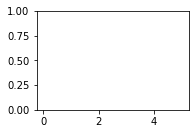

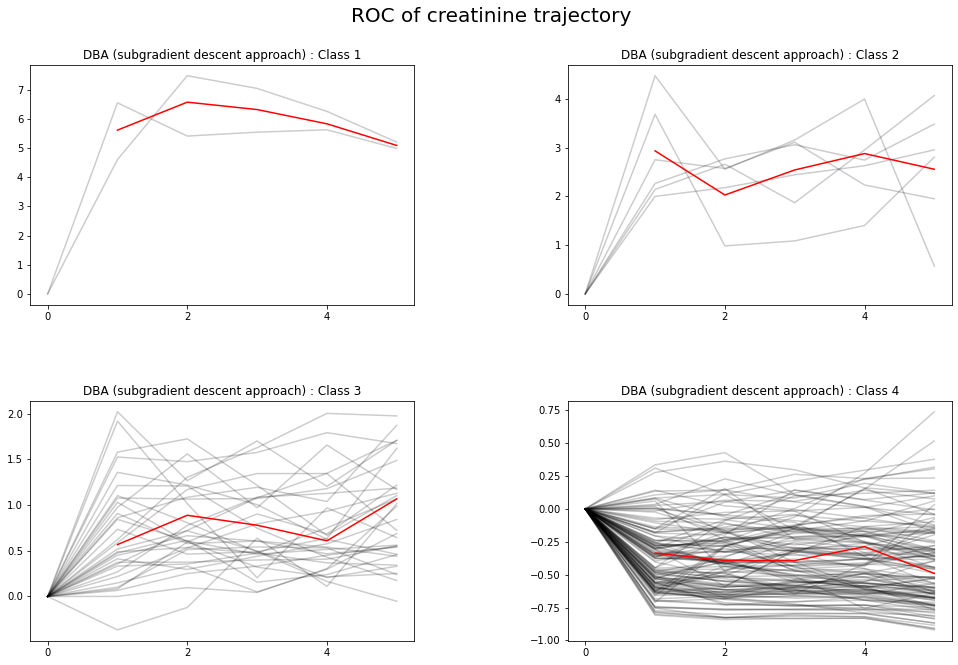

In [45]:
ax2 = plt.subplot(2, 2, 1)
plt.figure(figsize=(16,10))

for i in range(4):
    sam = df_scale_2.loc[df_scale_2["label"] == i+1].transpose()
    sam.drop(index="label", inplace=True)
    q = sam.transpose().to_numpy()
    length_of_sequence = q.shape[1]
    plt.subplot(2, 2, i+1, sharex=ax2)
    plt.title(f"DBA (subgradient descent approach) : Class {i+1}")
    plot_helper(dtw_barycenter_averaging_subgradient(q, max_iter=100, tol=1e-3))

plt.suptitle("ROC of creatinine trajectory", fontsize=20)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

In [27]:
aki_select.reset_index(inplace=True, drop=True)

In [31]:
df_2 = pd.concat([df_scale_2,aki_select], axis=1)

In [35]:
columns = ["age","sexfac_n","weight","cardiodis","renaldis","infectdis","gastrodis","hematodis","neurodis","rheumdis","oncoldis","surgdis","ht_n","dm_n","ckd_n","cad_n","cvd","malignancy_n","apache_ii","sofa_nonrenal_n","percentfluid_1",
          "vaso_n","mechvent_n","maxakinom","time2aki_n","rrt_any","hoslos_n","hospital_discharge_status_n","icu_los_n","icu_discharge_status_n","recovery_n","baseline","label"]

In [36]:
df_2 = df_2[columns]
df_2 = df_2.apply(convert, axis=1)

### Patient baseline characteristics and outcomes by  classes

In [37]:
group = df_2.groupby("label").mean()
group.transpose()

label,1.0,2.0,3.0,4.0
age,51.000000,75.000000,66.312500,67.248120
sexfac_n,0.500000,0.666667,0.406250,0.451128
weight,53.500000,64.500000,59.593750,60.481203
cardiodis,0.000000,0.333333,0.406250,0.503759
renaldis,0.000000,0.500000,0.125000,0.172932
infectdis,0.500000,0.833333,0.875000,0.909774
gastrodis,0.000000,0.166667,0.125000,0.090226
hematodis,0.000000,0.000000,0.031250,0.045113
neurodis,0.000000,0.000000,0.031250,0.030075
rheumdis,0.000000,0.000000,0.000000,0.030075


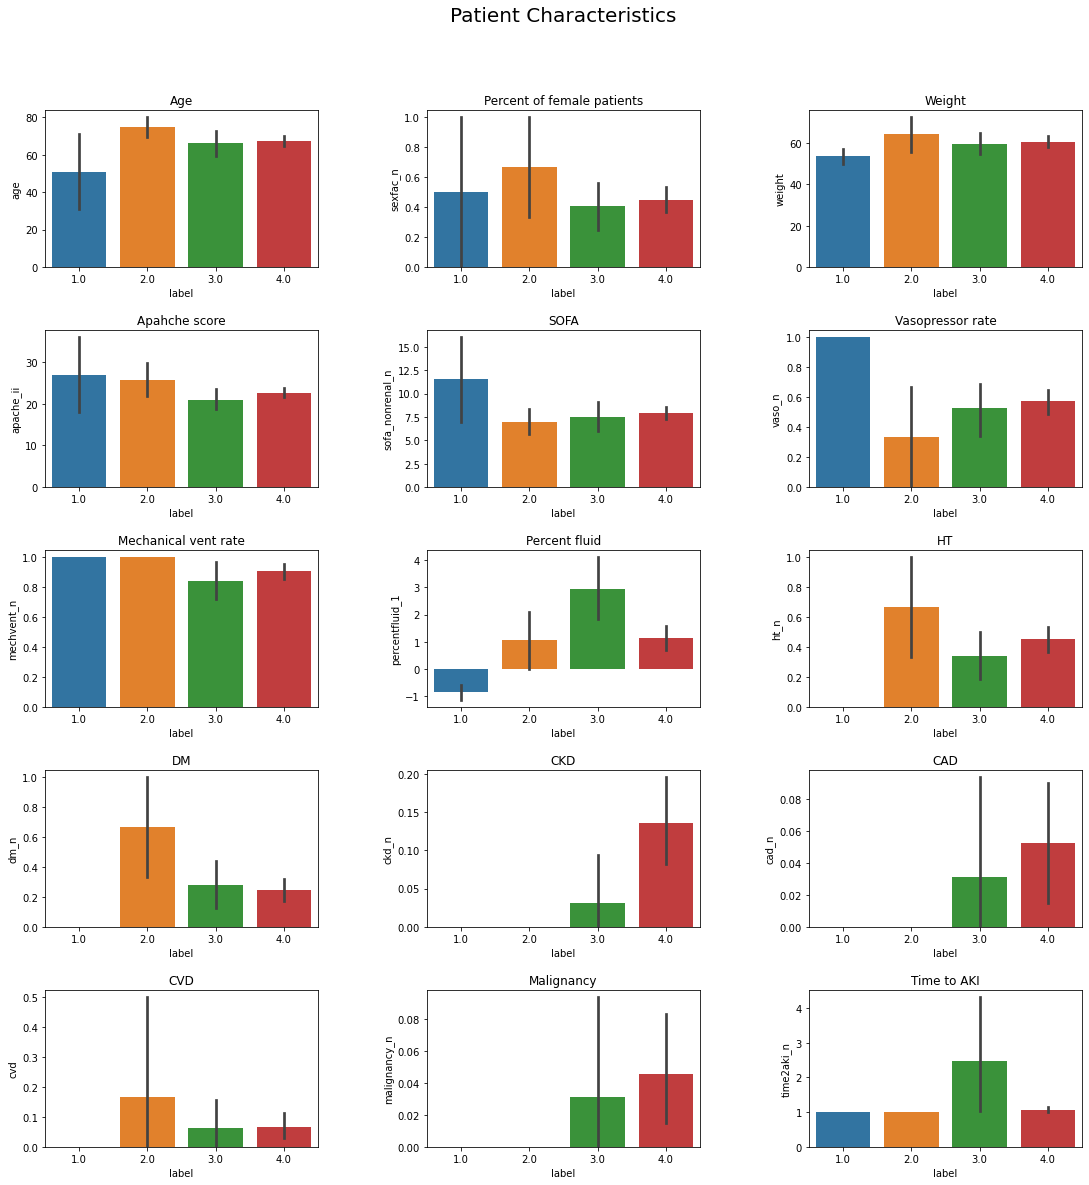

In [38]:
fig, axes = plt.subplots(5,3, figsize=(18,18), sharey=False)
fig.suptitle("Patient Characteristics", fontsize=20)

sns.barplot(ax=axes[0,0], data=df_2, x="label", y="age")
axes[0,0].set_title("Age")
sns.barplot(ax=axes[0,1], data=df_2, x="label", y="sexfac_n")
axes[0,1].set_title("Percent of female patients")
sns.barplot(ax=axes[0,2], data=df_2, x="label", y="weight")
axes[0,2].set_title("Weight")
sns.barplot(ax=axes[1,0], data=df_2, x="label", y="apache_ii")
axes[1,0].set_title("Apahche score")
sns.barplot(ax=axes[1,1], data=df_2, x="label", y="sofa_nonrenal_n")
axes[1,1].set_title("SOFA")
sns.barplot(ax=axes[1,2], data=df_2, x="label", y="vaso_n")
axes[1,2].set_title("Vasopressor rate")
sns.barplot(ax=axes[2,0], data=df_2, x="label", y="mechvent_n")
axes[2,0].set_title("Mechanical vent rate")
sns.barplot(ax=axes[2,1], data=df_2, x="label", y="percentfluid_1")
axes[2,1].set_title("Percent fluid")
sns.barplot(ax=axes[2,2], data=df_2, x="label", y="ht_n")
axes[2,2].set_title("HT")
sns.barplot(ax=axes[3,0], data=df_2, x="label", y="dm_n")
axes[3,0].set_title("DM")
sns.barplot(ax=axes[3,1], data=df_2, x="label", y="ckd_n")
axes[3,1].set_title("CKD")
sns.barplot(ax=axes[3,2], data=df_2, x="label", y="cad_n")
axes[3,2].set_title("CAD")
sns.barplot(ax=axes[4,0], data=df_2, x="label", y="cvd")
axes[4,0].set_title("CVD")
sns.barplot(ax=axes[4,1], data=df_2, x="label", y="malignancy_n")
axes[4,1].set_title("Malignancy")
sns.barplot(ax=axes[4,2], data=df_2, x="label", y="time2aki_n")
axes[4,2].set_title("Time to AKI")



plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

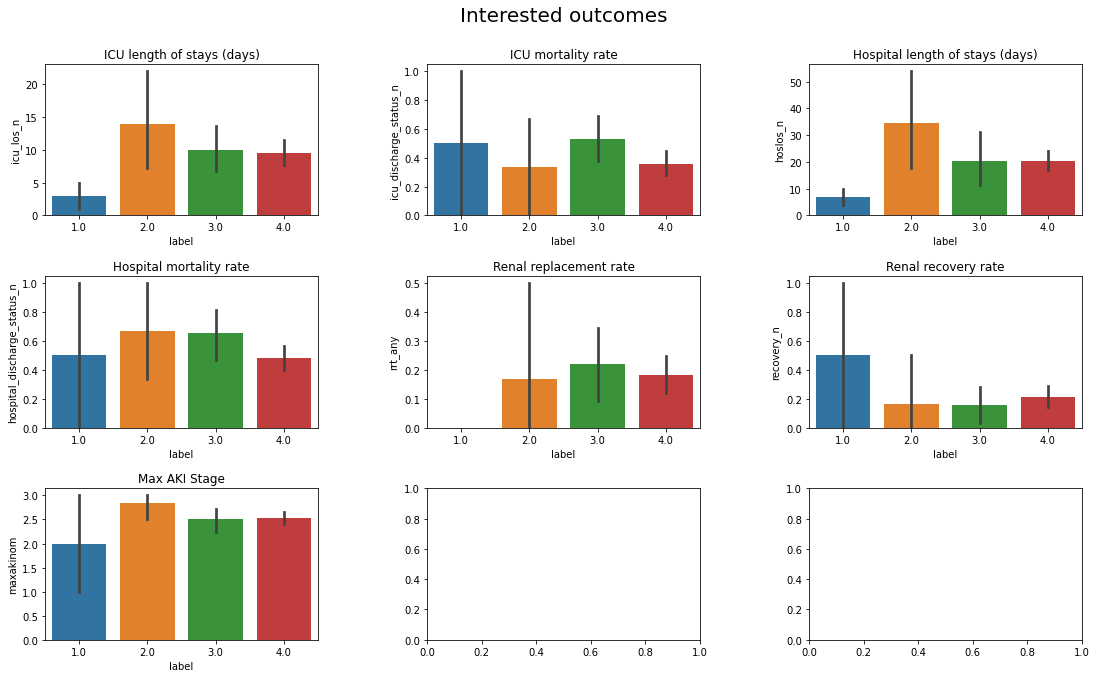

In [39]:
fig, axes = plt.subplots(3,3, figsize=(18,10), sharey=False)
fig.suptitle("Interested outcomes", fontsize=20)

sns.barplot(ax=axes[0,0], data=df_2, x="label", y="icu_los_n")
axes[0,0].set_title("ICU length of stays (days)")
sns.barplot(ax=axes[0,1], data=df_2, x="label", y="icu_discharge_status_n")
axes[0,1].set_title("ICU mortality rate")
sns.barplot(ax=axes[0,2], data=df_2, x="label", y="hoslos_n")
axes[0,2].set_title("Hospital length of stays (days)")
sns.barplot(ax=axes[1,0], data=df_2, x="label", y="hospital_discharge_status_n")
axes[1,0].set_title("Hospital mortality rate")
sns.barplot(ax=axes[1,1], data=df_2, x="label", y="rrt_any")
axes[1,1].set_title("Renal replacement rate")
sns.barplot(ax=axes[1,2], data=df_2, x="label", y="recovery_n")
axes[1,2].set_title("Renal recovery rate")
sns.barplot(ax=axes[2,0], data=df_2, x="label", y="maxakinom")
axes[2,0].set_title("Max AKI Stage")



plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()